In [38]:
from pyspark.sql import Row, DataFrame, HiveContext
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer

sqlContext_H = HiveContext(sc)

from scipy.sparse import lil_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 250)

import numpy as np
import copy
from collections import OrderedDict
from dateutil.parser import parse

from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


HOST = 'hdfs://ip-10-0-0-159.ec2.internal:8020'
#HOST = ''

In [2]:
secure_rdd = sc.textFile(HOST + "/users_info/SecureHealEmpTest.csv").persist()
first = secure_rdd.first()
header = first.split("|")
row_data = secure_rdd.filter(lambda x: x != first).map( lambda x: x.split("|") ) \
                        .map( lambda p: Row(**{header[i]:p[i] for i in range(len(header))}) ).persist()
secure_rdd.unpersist() 
users = sqlContext_H.createDataFrame(row_data).select("Employee", "ProcDesc", "DeptName", "Dept").persist()
row_data.unpersist()
sqlContext_H.registerDataFrameAsTable(users, "users")

In [3]:
users.limit(2).toPandas()

,Employee,ProcDesc,DeptName,Dept
0,100059,Edward Hospital,MED SURGICAL,6095
1,100067,Edward Hospital,CARDIAC MONITOR,8668


In [39]:
fields_list = ( "ACCESS_DTTM", "USER_ID", "WORKSTATION", "ACCESS_WEEK" )
data = sqlContext_H.read.parquet( 
        HOST + "/parquet3/08/*"
    #HOST + "/parquet3/08/Epic_Access_Log_20160807.parquet"
    #HOST + "../../hdfs/Epic_Access_Log_20160807.parquet"
    ).select(*fields_list).persist()

sqlContext_H.registerDataFrameAsTable(data, 'data')

In [40]:
data.limit(5).toPandas()

,ACCESS_DTTM,USER_ID,WORKSTATION,ACCESS_WEEK
0,2016-08-08 00:00:04,2102006,,32
1,2016-08-08 00:00:04,2102006,,32
2,2016-08-08 00:00:04,2102006,,32
3,2016-08-08 00:00:04,2102006,,32
4,2016-08-08 00:00:04,2102006,,32


In [43]:
############################# skip
users_one_month = sqlContext_H.sql("SELECT DISTINCT(USER_ID) AS count FROM data").toPandas()
users_one_month.to_csv("unique_users_08.csv", index=False, header=False)

In [6]:
%%time
query = " ".join([
        "SELECT ACCESS_WEEK, COUNT(*) as amount",
        "FROM data",
        "GROUP BY ACCESS_WEEK"
    ])
sqlContext_H.sql(query).show()

+-----------+--------+
|ACCESS_WEEK|  amount|
+-----------+--------+
|         31|46483911|
|         34|48507581|
|         35|28425743|
|         32|46740875|
|         33|47259959|
+-----------+--------+

CPU times: user 5.79 ms, sys: 724 µs, total: 6.51 ms
Wall time: 1min 7s


In [16]:
%%time
############################################################## skip

month = '08'
week = '31'
flag = False
if flag:
    all_users = sqlContext_H.sql("SELECT DISTINCT(USER_ID) AS count FROM data WHERE ACCESS_WEEK = '{}'".format(week))
    all_workstations = sqlContext_H.sql("SELECT DISTINCT(WORKSTATION) AS count FROM data WHERE ACCESS_WEEK = '{}'".format(week))
    all_users.write.format("com.databricks.spark.csv").mode('overwrite').save(HOST + "/csv/unique_users_{}_{}.csv".format(month, week))
    all_workstations.write.format("com.databricks.spark.csv").mode('overwrite').save(HOST + "/csv/unique_workstations_{}_{}.csv".format(month, week))

#total_users_of_week = sc.textFile(HOST + "csv/unique_users_{}_{}.csv".format(month, week)).count()
#print total_users_of_week

CPU times: user 2.55 ms, sys: 380 µs, total: 2.93 ms
Wall time: 10.4 s


In [6]:
%%time
data_f = data.filter("ACCESS_WEEK = '31'")
sqlContext_H.registerDataFrameAsTable(data_f, 'data_f')

CPU times: user 1.64 ms, sys: 0 ns, total: 1.64 ms
Wall time: 69.2 ms


In [7]:
query = lambda table: """
    SELECT mainT1.USER_ID, mainT1.WORKSTATION, mainT1.TF * mainT2.IDF AS TF_IDF
    FROM (SELECT T1.USER_ID, T1.WORKSTATION, T1.AMOUNT*1.0 / T2.TOTAL AS TF 
        FROM (SELECT USER_ID, WORKSTATION, COUNT(ACCESS_DTTM) AS AMOUNT
            FROM {table_name}
            GROUP BY USER_ID, WORKSTATION
        ) AS T1
        JOIN (SELECT USER_ID, COUNT(ACCESS_DTTM) AS TOTAL
            FROM {table_name}
            GROUP BY USER_ID
        ) AS T2
        ON T1.USER_ID = T2.USER_ID
    ) AS mainT1 JOIN (
        SELECT T.USER_ID, 
               log10( 1 + (SELECT COUNT(DISTINCT(USER_ID)) AS count FROM {table_name}) * 1.0 / COUNT(T.WORKSTATION) ) AS IDF
        FROM (SELECT USER_ID, WORKSTATION
            FROM {table_name}
            GROUP BY USER_ID, WORKSTATION
        ) AS T
        GROUP BY T.USER_ID
    ) AS mainT2 ON mainT1.USER_ID = mainT2.USER_ID
""".format(table_name=table)

df = sqlContext_H.sql(query("data_f")).persist()
sqlContext_H.registerDataFrameAsTable(df, 'df')

query = lambda table: " ".join([
                "SELECT t.USER_ID, t.WORKSTATION, t.TF_IDF",
                ", users.DeptName AS DEPT_NAME, users.Dept AS DEPT_ID, users.ProcDesc AS HOSPITAL",
                        "FROM {table_name} AS t",
                        "LEFT JOIN users ON t.USER_ID = users.Employee",
                    ]).format(table_name=table)

res = sqlContext_H.sql(query('df')).persist()

In [8]:
%%time
res.limit(5).toPandas()
#res.filter("DEPT_ID IS NULL").limit(10).toPandas()

CPU times: user 7.31 ms, sys: 706 µs, total: 8.02 ms
Wall time: 45.6 s


,USER_ID,WORKSTATION,TF_IDF,DEPT_NAME,DEPT_ID,HOSPITAL
0,100263,,0.009666,PF LAB,9200,Edward Hospital
1,100263,LABDT022,0.175067,PF LAB,9200,Edward Hospital
2,100263,LABDT028,2.209277,PF LAB,9200,Edward Hospital
3,100263,LABDT064,0.991328,PF LAB,9200,Edward Hospital
4,102536,XYDT095,0.611904,CRITICAL CARE,6000,Edward Hospital


In [9]:
#sample_res = res.limit(100)
sample_res = res

In [11]:
sample_res.select("USER_ID").distinct().count()

9710

In [12]:
%%time
print res.count()

61692
CPU times: user 1.33 ms, sys: 169 µs, total: 1.5 ms
Wall time: 247 ms


In [10]:
%%time

all_users = sqlContext_H.createDataFrame( 
        sc.textFile(HOST + "/csv/unique_users_08_31.csv").map(lambda p: Row(USER_ID=p)) 
    ).union( sqlContext_H.createDataFrame([Row(USER_ID='')]) ).persist()
all_workstations = sqlContext_H.createDataFrame( 
        sc.textFile(HOST + "/csv/unique_workstations_08_31.csv").map(lambda p: Row(WORKSTATION=p)) 
    ).union( sqlContext_H.createDataFrame([Row(WORKSTATION='')]) ).persist()

indexerU = StringIndexer(inputCol="USER_ID", outputCol="USER_ID_Index").fit(all_users)
indexerW = StringIndexer(inputCol="WORKSTATION", outputCol="WORKSTATION_Index").fit(all_workstations)

all_users.unpersist()
all_workstations.unpersist()

indexedU_df = indexerU.transform(sample_res).withColumn(
        "USER_ID_Index", F.col("USER_ID_Index").cast(IntegerType())
    ).persist()

table = indexerW.transform(indexedU_df).withColumn(
        "WORKSTATION_Index", F.col("WORKSTATION_Index").cast(IntegerType())
    ).persist()


t = table.select("USER_ID_Index", "WORKSTATION_Index", "TF_IDF").toPandas()

total_users = sc.textFile(HOST + "/csv/unique_users_08_31.csv").count()
total_workstations = sc.textFile(HOST + "/csv/unique_workstations_08_31.csv").count()

print total_users, total_workstations

def sparse_df_to_array(df, shape):
    """ Convert sparse dataframe to sparse array csr_matrix used by scikit learn. """
    arr = lil_matrix(shape, dtype=np.float32)
    l = []
    for i in range(df.shape[0]):
        l.append(df.ix[i, "USER_ID_Index"])
        arr[df.ix[i, "USER_ID_Index"], df.ix[i, "WORKSTATION_Index"]] = df.ix[i, "TF_IDF"]
    print arr.shape
    return arr.tocsr(), sorted(l)

m, users_list = sparse_df_to_array(t, (total_users+1, total_workstations+1))
print "Sparse matrix is built ..."

9710 9697
(9711, 9698)
Sparse matrix is built ...
CPU times: user 2.22 s, sys: 63.4 ms, total: 2.28 s
Wall time: 9.24 s


In [16]:
table.orderBy("USER_ID_Index", "WORKSTATION_Index").limit(15).toPandas()

,USER_ID,WORKSTATION,TF_IDF,DEPT_NAME,DEPT_ID,HOSPITAL,USER_ID_Index,WORKSTATION_Index
0,17319,AENWOFF21,3.987264,None,None,None,0,3226
1,9936,,0.017244,None,None,None,1,237
2,9936,WS1000,0.121492,None,None,None,1,502
3,9936,HYP718,0.010973,None,None,None,1,1998
4,9936,WS0997,0.282175,None,None,None,1,3703
5,9936,WS0995,0.040759,None,None,None,1,5825
6,9936,WS0999,0.254741,None,None,None,1,6512
7,9936,HYP716,0.004703,None,None,None,1,7233
8,9936,HYP720,1.119293,None,None,None,1,8286
9,9936,WS0998,1.181999,None,None,None,1,8428


In [11]:
%%time
new_table = table.orderBy("USER_ID_Index", "WORKSTATION_Index").toPandas()

CPU times: user 345 ms, sys: 14.6 ms, total: 360 ms
Wall time: 1.95 s


In [12]:
%%time
new_table.head()

CPU times: user 333 µs, sys: 21 µs, total: 354 µs
Wall time: 403 µs


,USER_ID,WORKSTATION,TF_IDF,DEPT_NAME,DEPT_ID,HOSPITAL,USER_ID_Index,WORKSTATION_Index
0,17319,AENWOFF21,3.987264,None,None,None,0,3226
1,9936,,0.017244,None,None,None,1,237
2,9936,WS1000,0.121492,None,None,None,1,502
3,9936,HYP718,0.010973,None,None,None,1,1998
4,9936,WS0997,0.282175,None,None,None,1,3703


In [13]:
dict_with_dept = {}
index_count = 0
for index, row in new_table.iterrows():
    try:
        key = row['DEPT_ID']+'|'+row['HOSPITAL']
    except:
        key = None
    if key not in dict_with_dept:
        dict_with_dept[key] = [index_count, set([row['USER_ID_Index']])]
        index_count += 1
    else:
        dict_with_dept[key][-1] = dict_with_dept[key][-1].union(set([row['USER_ID_Index']]))
        
print(len(dict_with_dept))

327


In [18]:
%%time
svd = TruncatedSVD(n_components=3000, n_iter=25, random_state=42)
svd.fit(m) 
print "Model is built ..."
print "svd.explained_variance_ratio_.sum() =", svd.explained_variance_ratio_.sum()

Model is built ...
svd.explained_variance_ratio_.sum() = 0.882867407477
CPU times: user 13min 27s, sys: 9.96 s, total: 13min 37s
Wall time: 13min 38s


In [19]:
%%time
main1 = svd.transform(m)
main2 = svd.inverse_transform(main1)

CPU times: user 5min 38s, sys: 227 ms, total: 5min 38s
Wall time: 5min 38s


In [20]:
print main1.shape
print main1

(9711, 3000)
[[  0.00000000e+00   7.50945562e-17  -4.20228136e-16 ...,   1.03804709e-09
    4.89637921e-10  -1.96778836e-10]
 [  6.79486981e-05   1.72850724e-02  -5.46513778e-10 ...,  -4.05211315e-04
   -2.70673338e-03   3.94898720e-05]
 [  3.98722094e+00  -1.57482388e-02  -2.23494280e-09 ...,  -1.40930038e-04
    9.87655845e-06   7.07254967e-06]
 ..., 
 [  1.35360579e-03   3.48075184e-01  -1.14713615e-08 ...,   3.79539321e-02
   -3.81920586e-02   3.91325052e-02]
 [  3.98722094e+00  -1.57482388e-02  -2.23494280e-09 ...,  -1.40930038e-04
    9.87655845e-06   7.07254967e-06]
 [  1.61470971e-04   3.68857709e-02  -1.15810830e-09 ...,   3.29861694e-03
   -8.12946196e-03  -1.09311895e-02]]


In [23]:
print main2.shape
print main2

(9711, 9698)
[[  2.57376183e-12  -3.14759097e-12  -4.10029224e-12 ...,   2.82244677e-11
   -2.87204996e-10   7.21847064e-16]
 [  2.84844248e-08  -3.16328615e-06   1.80661509e-08 ...,   3.69477624e-07
   -2.13108194e-05  -4.28091884e-12]
 [  5.76198901e-07   4.25404260e-08  -2.77340777e-08 ...,  -3.54839896e-07
   -1.49828364e-07   3.49561014e-12]
 ..., 
 [  8.77786353e-07   1.83399125e-04   2.18061932e-06 ...,   2.26194503e-05
   -1.33120580e-03   1.02743555e-09]
 [  5.76198901e-07   4.25404260e-08  -2.77340777e-08 ...,  -3.54839896e-07
   -1.49828364e-07   3.49561014e-12]
 [ -8.93295701e-08  -6.00159014e-05  -9.77183814e-08 ...,  -1.49509421e-06
   -1.36081628e-04  -6.97000532e-10]]


In [21]:
np.save('main1_svd.npy', main1)
np.save('main2_svd.npy', main2)

In [22]:
main3 = np.load('main1_svd.npy')
print main3.shape
print main3

(9711, 3000)
[[  0.00000000e+00   7.50945562e-17  -4.20228136e-16 ...,   1.03804709e-09
    4.89637921e-10  -1.96778836e-10]
 [  6.79486981e-05   1.72850724e-02  -5.46513778e-10 ...,  -4.05211315e-04
   -2.70673338e-03   3.94898720e-05]
 [  3.98722094e+00  -1.57482388e-02  -2.23494280e-09 ...,  -1.40930038e-04
    9.87655845e-06   7.07254967e-06]
 ..., 
 [  1.35360579e-03   3.48075184e-01  -1.14713615e-08 ...,   3.79539321e-02
   -3.81920586e-02   3.91325052e-02]
 [  3.98722094e+00  -1.57482388e-02  -2.23494280e-09 ...,  -1.40930038e-04
    9.87655845e-06   7.07254967e-06]
 [  1.61470971e-04   3.68857709e-02  -1.15810830e-09 ...,   3.29861694e-03
   -8.12946196e-03  -1.09311895e-02]]


In [24]:
main4 = np.load('main2_svd.npy')
print main4.shape
print main4

(9711, 9698)
[[  2.57376183e-12  -3.14759097e-12  -4.10029224e-12 ...,   2.82244677e-11
   -2.87204996e-10   7.21847064e-16]
 [  2.84844248e-08  -3.16328615e-06   1.80661509e-08 ...,   3.69477624e-07
   -2.13108194e-05  -4.28091884e-12]
 [  5.76198901e-07   4.25404260e-08  -2.77340777e-08 ...,  -3.54839896e-07
   -1.49828364e-07   3.49561014e-12]
 ..., 
 [  8.77786353e-07   1.83399125e-04   2.18061932e-06 ...,   2.26194503e-05
   -1.33120580e-03   1.02743555e-09]
 [  5.76198901e-07   4.25404260e-08  -2.77340777e-08 ...,  -3.54839896e-07
   -1.49828364e-07   3.49561014e-12]
 [ -8.93295701e-08  -6.00159014e-05  -9.77183814e-08 ...,  -1.49509421e-06
   -1.36081628e-04  -6.97000532e-10]]


In [14]:
%%time
def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    return ['#'+i for i in colors]
colors = get_spaced_colors(len(dict_with_dept))

CPU times: user 432 µs, sys: 9 µs, total: 441 µs
Wall time: 237 µs


In [15]:
np.save('dict_with_dept.npy', dict_with_dept)
np.save('colors.npy', colors)

In [ ]:
dict_with_dept = np.load('dict_with_dept.npy').tolist()

In [26]:
colors = list(np.load('colors.npy'))

328

In [17]:
%%time
count_dep_5 = 0
l1 = []
count_dep_5_10 = 0
l2 = []
count_dep_10_15 = 0
l3 = []
count_dep_15_20 = 0
l4 = []
count_dep_20 = 0
l5 = []
for k, v in dict_with_dept.items():
    if len(v[-1]) < 5:
        count_dep_5 += 1
        l1.append(k)
    elif 5 <= len(v[-1]) <= 10:
        count_dep_5_10 += 1
        l2.append(k)
    elif 10 < len(v[-1]) <= 15:
        count_dep_10_15 += 1
        l3.append(k)
    elif 15 < len(v[-1]) <= 20:
        count_dep_15_20 += 1
        l4.append(k)
    elif len(v[-1]) > 20:
        count_dep_20 += 1
        l5.append(k)
print(count_dep_5, count_dep_5_10, count_dep_10_15, count_dep_15_20, count_dep_20)

(155, 66, 27, 25, 54)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.48 ms


In [ ]:
#print some l
print l2[:10], '\n', l3[:10], '\n', l4[:10],'\n', l5[:10]

[u'7110|Edward Hospital', u'3704|Elmhurst Memorial Hospital', u'8500|Edward Hospital', u'7107|Elmhurst Memorial Hospital', u'3726|Elmhurst Memorial Hospital', u'3745|Elmhurst Memorial Hospital', u'3365|Edward Health Ventures', u'9034|Naperville Psychiatric Venture', u'3584|Elmhurst Memorial Hospital', u'7070|Edward Hospital'] 
[u'8690|Edward Hospital', u'9023|Naperville Psychiatric Venture', u'3377|Edward Health Ventures', u'7104|Edward Hospital', u'3375|Edward Health Ventures', u'3358|Edward Health Ventures', u'7052|Edward Hospital', u'3347|Edward Health Ventures', u'7550|Edward Hospital', u'8641|Edward Hospital'] 
[u'3739|Elmhurst Memorial Hospital', u'3337|Edward Health Ventures', u'7086|Edward Hospital', u'7055|Edward Hospital', u'8581|Edward Hospital', u'3405|Edward Health Ventures', u'7610|Edward Hospital', u'6096|Edward Hospital', u'9027|Naperville Psychiatric Venture', u'7107|Edward Hospital'] 
[u'6031|Edward Hospital', u'6075|Edward Hospital', u'8572|Edward Hospital', u'8644|E

---
# One week

In [27]:
%%time
similarities = euclidean_distances(main1)

CPU times: user 5min 39s, sys: 132 ms, total: 5min 39s
Wall time: 5min 39s


In [28]:
np.save('similarities.npy', similarities)

In [30]:
seed = np.random.RandomState(seed=3)

In [31]:
%%time
mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

CPU times: user 18min 29s, sys: 6min 29s, total: 24min 59s
Wall time: 25min


In [32]:
np.save('pos.npy', pos)

In [33]:
%%time
nmds = manifold.MDS(n_components=2, metric=False, max_iter=300, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

CPU times: user 1min 41s, sys: 11.9 s, total: 1min 53s
Wall time: 1min 53s


In [34]:
np.save('npos.npy', npos)

---
### test with loading data

In [ ]:
%%time
### 5-10

### add departament in list
filtred_deps = l2[:3]

similarities_t = np.load('similarities.npy')

pos_t = np.load('pos.npy')

npos_t = np.load('npos.npy')

X_true = np.load('main1_svd.npy')

def build_graff(filtred_deps, similarities_t, pos_t, npos_t, X_true):
    # Rescale the data
    pos_t *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos_t ** 2).sum())
    npos_t *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos_t ** 2).sum())

    # Rotate the data
    clf = PCA(n_components=2)
    X_true = clf.fit_transform(X_true)

    pos_t = clf.fit_transform(pos_t)

    npos_t = clf.fit_transform(npos_t)

    #fig = plt.figure(1)
    fig = plt.figure(figsize=(14, 14))
    ax = plt.axes([0., 0., 1., 1.])

    s = 200
    max_ind = 0 
    lables_d = {}
    print("creating scatters...")
    for ind, val in enumerate(zip(npos_t[:, 0], npos_t[:, 1])):
        for k, v in dict_with_dept.items():
            if ind in v[-1] and k != None and (5 <= len(v[-1]) <= 10) and k in filtred_deps:
                #print(colors[v[0]], k)
                lables_d[k] = str(ind) + '_plt'
                locals()[str(ind) + '_plt'] = plt.scatter(val[0], val[1], color=colors[v[0]], s=s, lw=0, label=k)

    l_colors = []
    l_lable = []
    print("scatters created...")
    for ind_l, val_l in lables_d.items():
        l_colors.append(locals()[val_l])
        l_lable.append(ind_l)
    print("creating legend...")
    plt.legend(l_colors, l_lable, scatterpoints=1, loc='best', shadow=False)

    
    similarities_t = similarities_t.max() / similarities_t * 100
    similarities_t[np.isinf(similarities_t)] = 0

    print("geting segments...")
    segments = [[X_true[i, :], X_true[j, :]]
                for i in xrange(len(pos_t)) for j in xrange(len(pos_t))]
    print("segments finded...")
    values = np.abs(similarities_t)
    print("creating LineCollection...")
    lc = LineCollection(segments,
                        zorder=0, cmap=plt.cm.Blues,
                        norm=plt.Normalize(0, values.max()))
    lc.set_array(similarities_t.flatten())
    lc.set_linewidths(0.7 * np.ones(len(segments)))
    ax.add_collection(lc)
    print("draw graff...")
    plt.show()
    
build_graff(filtred_deps, similarities_t, pos_t, npos_t, X_true)

creating scatters...
scatters created...
creating legend...


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in divide


geting segments...
----------------------------------------

Traceback (most recent call last):
  File "/usr/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python2.7/SocketServer.py", line 649, in __init__
    self.handle()
  File "/home/ubuntu/spark-2.0.1-bin-hadoop2.6/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/home/ubuntu/spark-2.0.1-bin-hadoop2.6/python/pyspark/serializers.py", line 545, in read_int
    raise EOFError
EOFError



Exception happened during processing of request from ('127.0.0.1', 51615)
----------------------------------------


In [ ]:
%%time
similarities_t = np.load('similarities.npy')

pos_t = np.load('pos.npy')

npos_t = np.load('npos.npy')

X_true = np.load('main1_svd.npy')

print("geting segments...")
#print X_true.shape
#print ([X_true[9710, :], X_true[9710, :]])
#print len(pos_t)
segments = []
for i in xrange(len(pos_t)):
    for j in xrange(len(pos_t)):
        segments.append([X_true[i, :], X_true[j, :]])
print "done"
#segments = [[X_true[i, :], X_true[j, :]]
                #for i in xrange(len(pos_t)) for j in xrange(len(pos_t))]

geting segments...


---

In [ ]:
%%time
### 5-10

### add departament in list
filtred_deps = l2[:3]

seed = np.random.RandomState(seed=3)
similarities = euclidean_distances(main1)

mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=300, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

X_true = main1

# Rescale the data
pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

#fig = plt.figure(1)
fig = plt.figure(figsize=(14, 14))
ax = plt.axes([0., 0., 1., 1.])

s = 200
max_ind = 0 
lables_d = {}
for ind, val in enumerate(zip(npos[:, 0], npos[:, 1])):
    for k, v in dict_with_dept.items():
        if ind in v[-1] and k != None and (5 <= len(v[-1]) <= 10) and k in filtred_deps:
            #print(colors[v[0]], k)
            lables_d[k] = str(ind) + '_plt'
            globals()[str(ind) + '_plt'] = plt.scatter(val[0], val[1], color=colors[v[0]], s=s, lw=0, label=k)

l_colors = []
l_lable = []
for ind_l, val_l in lables_d.items():
    l_colors.append(globals()[val_l])
    l_lable.append(ind_l)
plt.legend(l_colors, l_lable, scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0


segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(0.7 * np.ones(len(segments)))
ax.add_collection(lc)

plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in divide


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 37686)
----------------------------------------


Traceback (most recent call last):
  File "/usr/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python2.7/SocketServer.py", line 649, in __init__
    self.handle()
  File "/home/ubuntu/spark-2.0.1-bin-hadoop2.6/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/home/ubuntu/spark-2.0.1-bin-hadoop2.6/python/pyspark/serializers.py", line 545, in read_int
    raise EOFError
EOFError


In [ ]:
%%time
### 11-15 

### add departament in list
filtred_deps = l3[:3]

seed = np.random.RandomState(seed=3)
similarities = euclidean_distances(main1)

mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=300, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

X_true = main1

# Rescale the data
pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

#fig = plt.figure(1)
fig = plt.figure(figsize=(14, 14))
ax = plt.axes([0., 0., 1., 1.])

s = 200

max_ind = 0 
lables_d = {}
for ind, val in enumerate(zip(npos[:, 0], npos[:, 1])):
    for k, v in dict_with_dept.items():
        if ind in v[-1] and k != None and (10 < len(v[-1]) <= 15) and k in filtred_deps:
            #print(colors[v[0]], k)
            lables_d[k] = str(ind) + '_plt'
            globals()[str(ind) + '_plt'] = plt.scatter(val[0], val[1], color=colors[v[0]], s=s, lw=0, label=k)

l_colors = []
l_lable = []
for ind_l, val_l in lables_d.items():
    l_colors.append(globals()[val_l])
    l_lable.append(ind_l)
plt.legend(l_colors, l_lable, scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0


segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(0.7 * np.ones(len(segments)))
ax.add_collection(lc)

plt.show()

In [ ]:
%%time
### 16-20 

### add departament in list
filtred_deps = l4[:3]

seed = np.random.RandomState(seed=3)
similarities = euclidean_distances(main1)

mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=300, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

X_true = main1

# Rescale the data
pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

#fig = plt.figure(1)
fig = plt.figure(figsize=(14, 14))
ax = plt.axes([0., 0., 1., 1.])

s = 200

max_ind = 0 
lables_d = {}
for ind, val in enumerate(zip(npos[:, 0], npos[:, 1])):
    for k, v in dict_with_dept.items():
        if ind in v[-1] and k != None and (15 < len(v[-1]) <= 20) and k in filtred_deps:
            #print(colors[v[0]], k)
            lables_d[k] = str(ind) + '_plt'
            globals()[str(ind) + '_plt'] = plt.scatter(val[0], val[1], color=colors[v[0]], s=s, lw=0, label=k)

l_colors = []
l_lable = []
for ind_l, val_l in lables_d.items():
    l_colors.append(globals()[val_l])
    l_lable.append(ind_l)
plt.legend(l_colors, l_lable, scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0


segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(0.7 * np.ones(len(segments)))
ax.add_collection(lc)

plt.show()

In [ ]:
%%time
### >21 

### add departament in list
filtred_deps = l5[:3]

seed = np.random.RandomState(seed=3)
similarities = euclidean_distances(main1)

mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=300, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

X_true = main1

# Rescale the data
pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

#fig = plt.figure(1)
fig = plt.figure(figsize=(14, 14))
ax = plt.axes([0., 0., 1., 1.])

s = 200

max_ind = 0 
lables_d = {}
for ind, val in enumerate(zip(npos[:, 0], npos[:, 1])):
    for k, v in dict_with_dept.items():
        if ind in v[-1] and k != None and (len(v[-1]) > 20) and k in filtred_deps:
            #print(colors[v[0]], k)
            lables_d[k] = str(ind) + '_plt'
            globals()[str(ind) + '_plt'] = plt.scatter(val[0], val[1], color=colors[v[0]], s=s, lw=0, label=k)

l_colors = []
l_lable = []
for ind_l, val_l in lables_d.items():
    l_colors.append(globals()[val_l])
    l_lable.append(ind_l)
plt.legend(l_colors, l_lable, scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0


segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(0.7 * np.ones(len(segments)))
ax.add_collection(lc)

plt.show()

---

---
# One day

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in divide
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


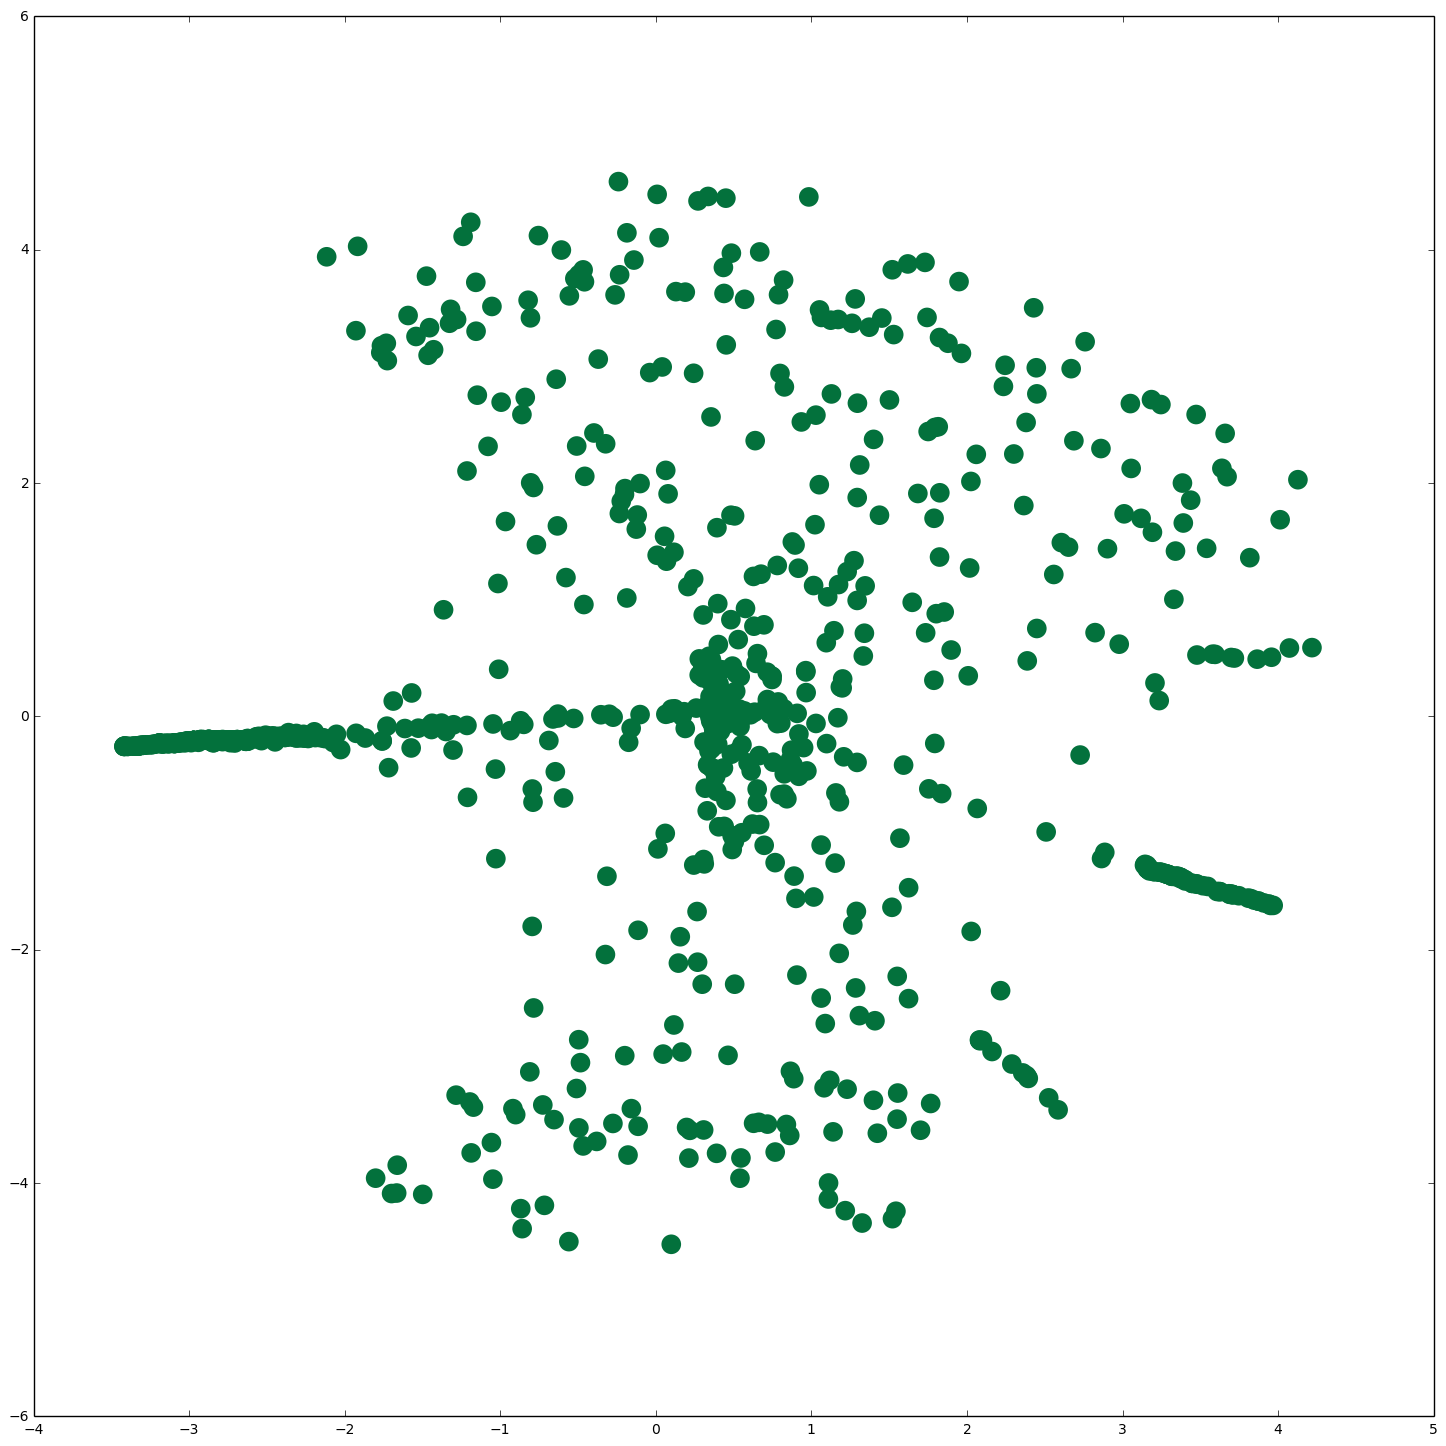

CPU times: user 2min 46s, sys: 15.9 s, total: 3min 2s
Wall time: 3min 2s


In [25]:
%%time

seed = np.random.RandomState(seed=3)
similarities = euclidean_distances(main1)

mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=300, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

X_true = main1

# Rescale the data
pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

#fig = plt.figure(1)
fig = plt.figure(figsize=(14, 14))
ax = plt.axes([0., 0., 1., 1.])

s = 200

max_ind = 0 
for ind, val in enumerate(zip(npos[:, 0], npos[:, 1])):
    for k, v in dict_with_dept.items():
        if ind in v[-1] and k == None:
            plt.scatter(val[0], val[1], color=colors[v[0]], s=s, lw=0, label="None")


similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0

segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(0 * np.ones(len(segments)))
ax.add_collection(lc)

plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in divide


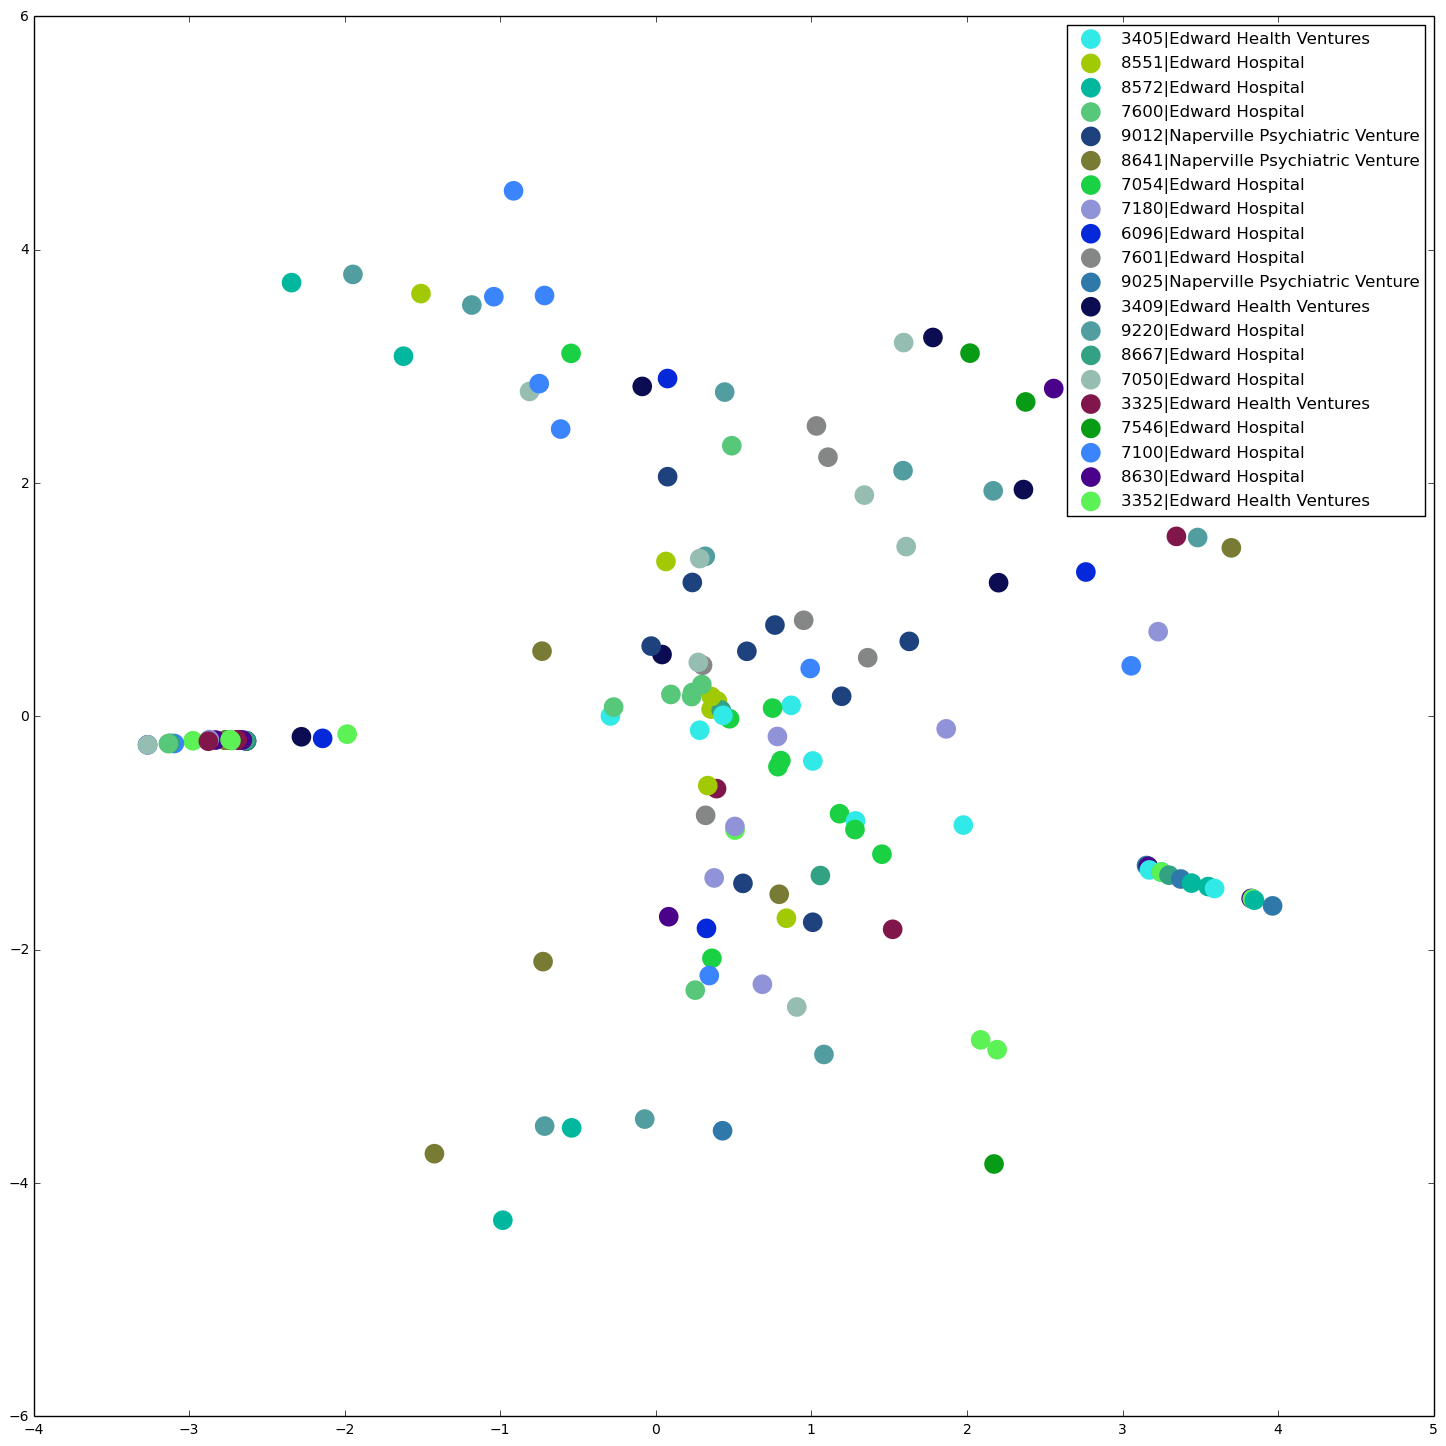

CPU times: user 2min 49s, sys: 2.57 s, total: 2min 51s
Wall time: 2min 51s


In [27]:
%%time
### 5-10
seed = np.random.RandomState(seed=3)
similarities = euclidean_distances(main1)

mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=300, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

X_true = main1

# Rescale the data
pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

#fig = plt.figure(1)
fig = plt.figure(figsize=(14, 14))
ax = plt.axes([0., 0., 1., 1.])

s = 200
max_ind = 0 
lables_d = {}
for ind, val in enumerate(zip(npos[:, 0], npos[:, 1])):
    for k, v in dict_with_dept.items():
        if ind in v[-1] and k != None and (5 <= len(v[-1]) <= 10):
            #print(colors[v[0]], k)
            lables_d[k] = str(ind) + '_plt'
            globals()[str(ind) + '_plt'] = plt.scatter(val[0], val[1], color=colors[v[0]], s=s, lw=0, label=k)

l_colors = []
l_lable = []
for ind_l, val_l in lables_d.items():
    l_colors.append(globals()[val_l])
    l_lable.append(ind_l)
plt.legend(l_colors, l_lable, scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0


segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(0 * np.ones(len(segments)))
ax.add_collection(lc)

plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in divide


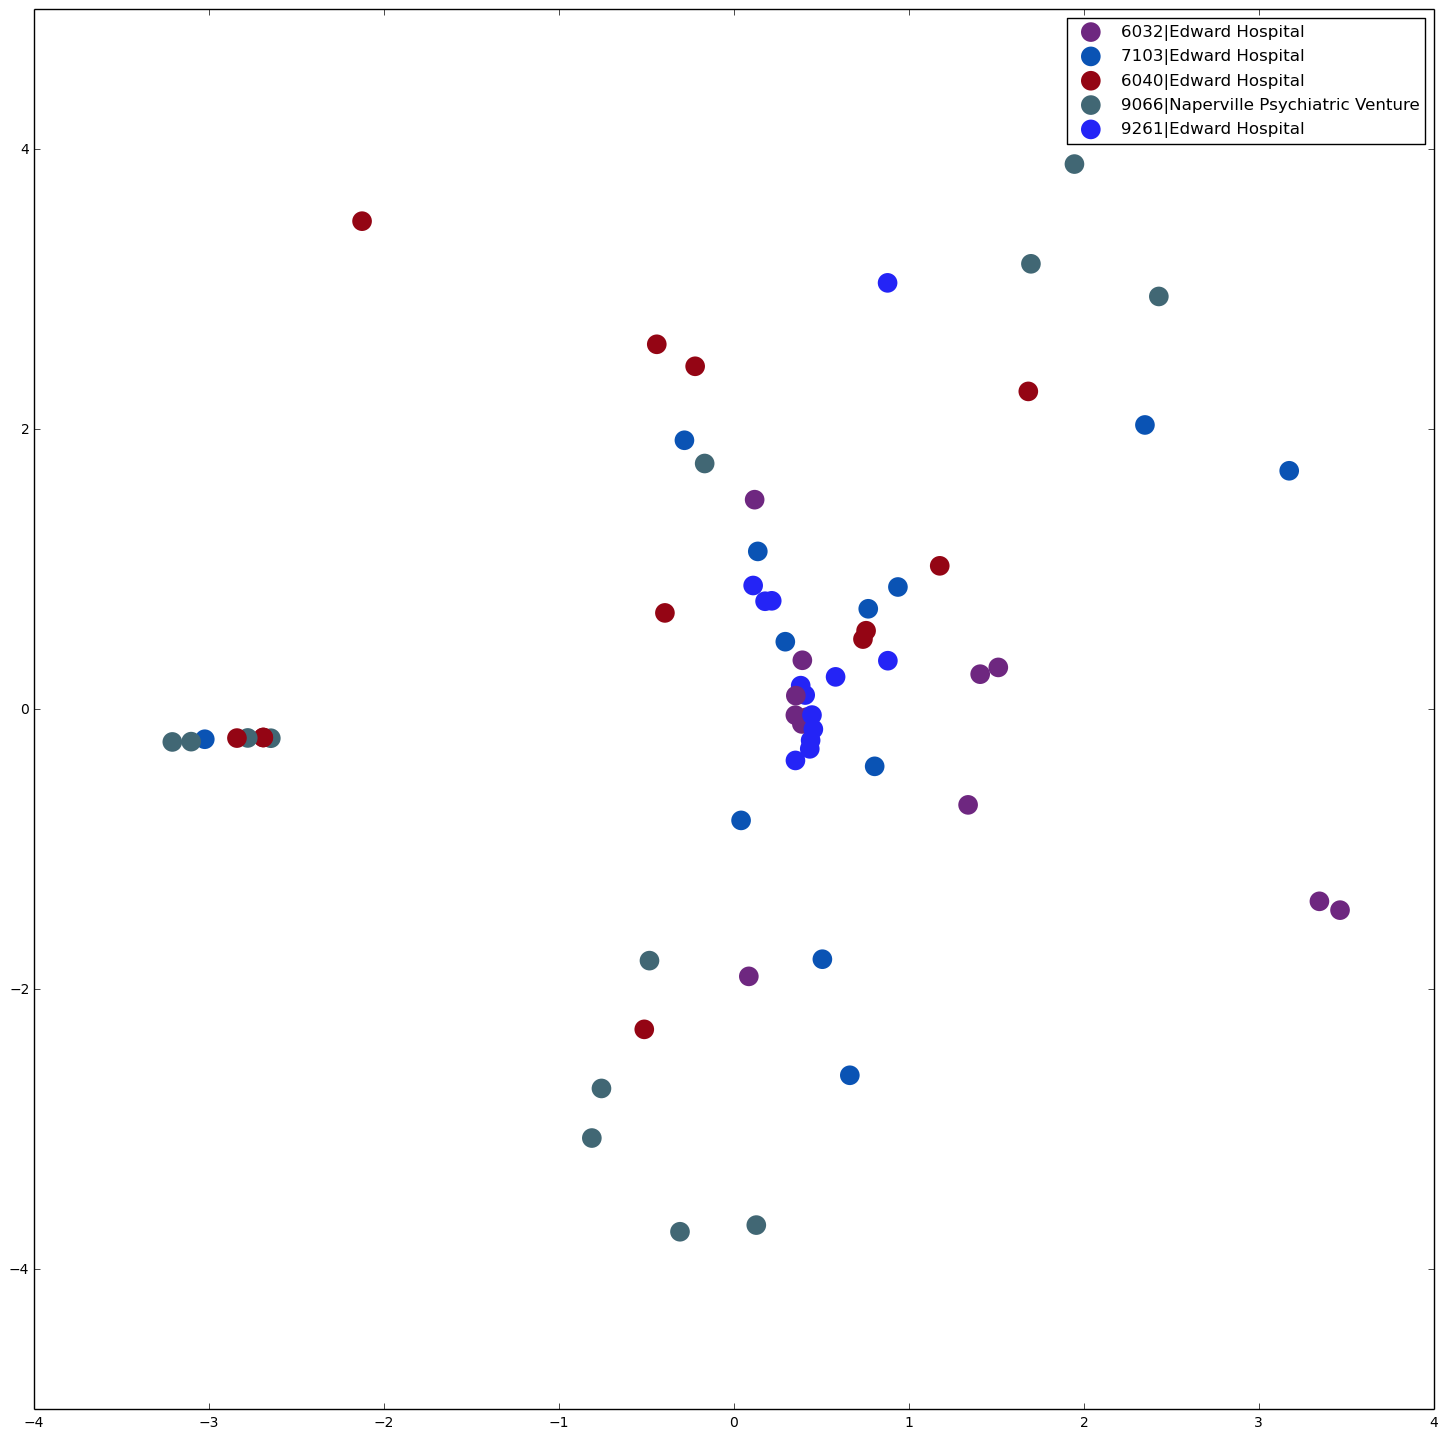

CPU times: user 2min 51s, sys: 1.2 s, total: 2min 52s
Wall time: 2min 52s


In [28]:
%%time
### 11-15 
seed = np.random.RandomState(seed=3)
similarities = euclidean_distances(main1)

mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=300, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

X_true = main1

# Rescale the data
pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

#fig = plt.figure(1)
fig = plt.figure(figsize=(14, 14))
ax = plt.axes([0., 0., 1., 1.])

s = 200

max_ind = 0 
lables_d = {}
for ind, val in enumerate(zip(npos[:, 0], npos[:, 1])):
    for k, v in dict_with_dept.items():
        if ind in v[-1] and k != None and (10 < len(v[-1]) <= 15):
            #print(colors[v[0]], k)
            lables_d[k] = str(ind) + '_plt'
            globals()[str(ind) + '_plt'] = plt.scatter(val[0], val[1], color=colors[v[0]], s=s, lw=0, label=k)

l_colors = []
l_lable = []
for ind_l, val_l in lables_d.items():
    l_colors.append(globals()[val_l])
    l_lable.append(ind_l)
plt.legend(l_colors, l_lable, scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0


segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(0 * np.ones(len(segments)))
ax.add_collection(lc)

plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in divide
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


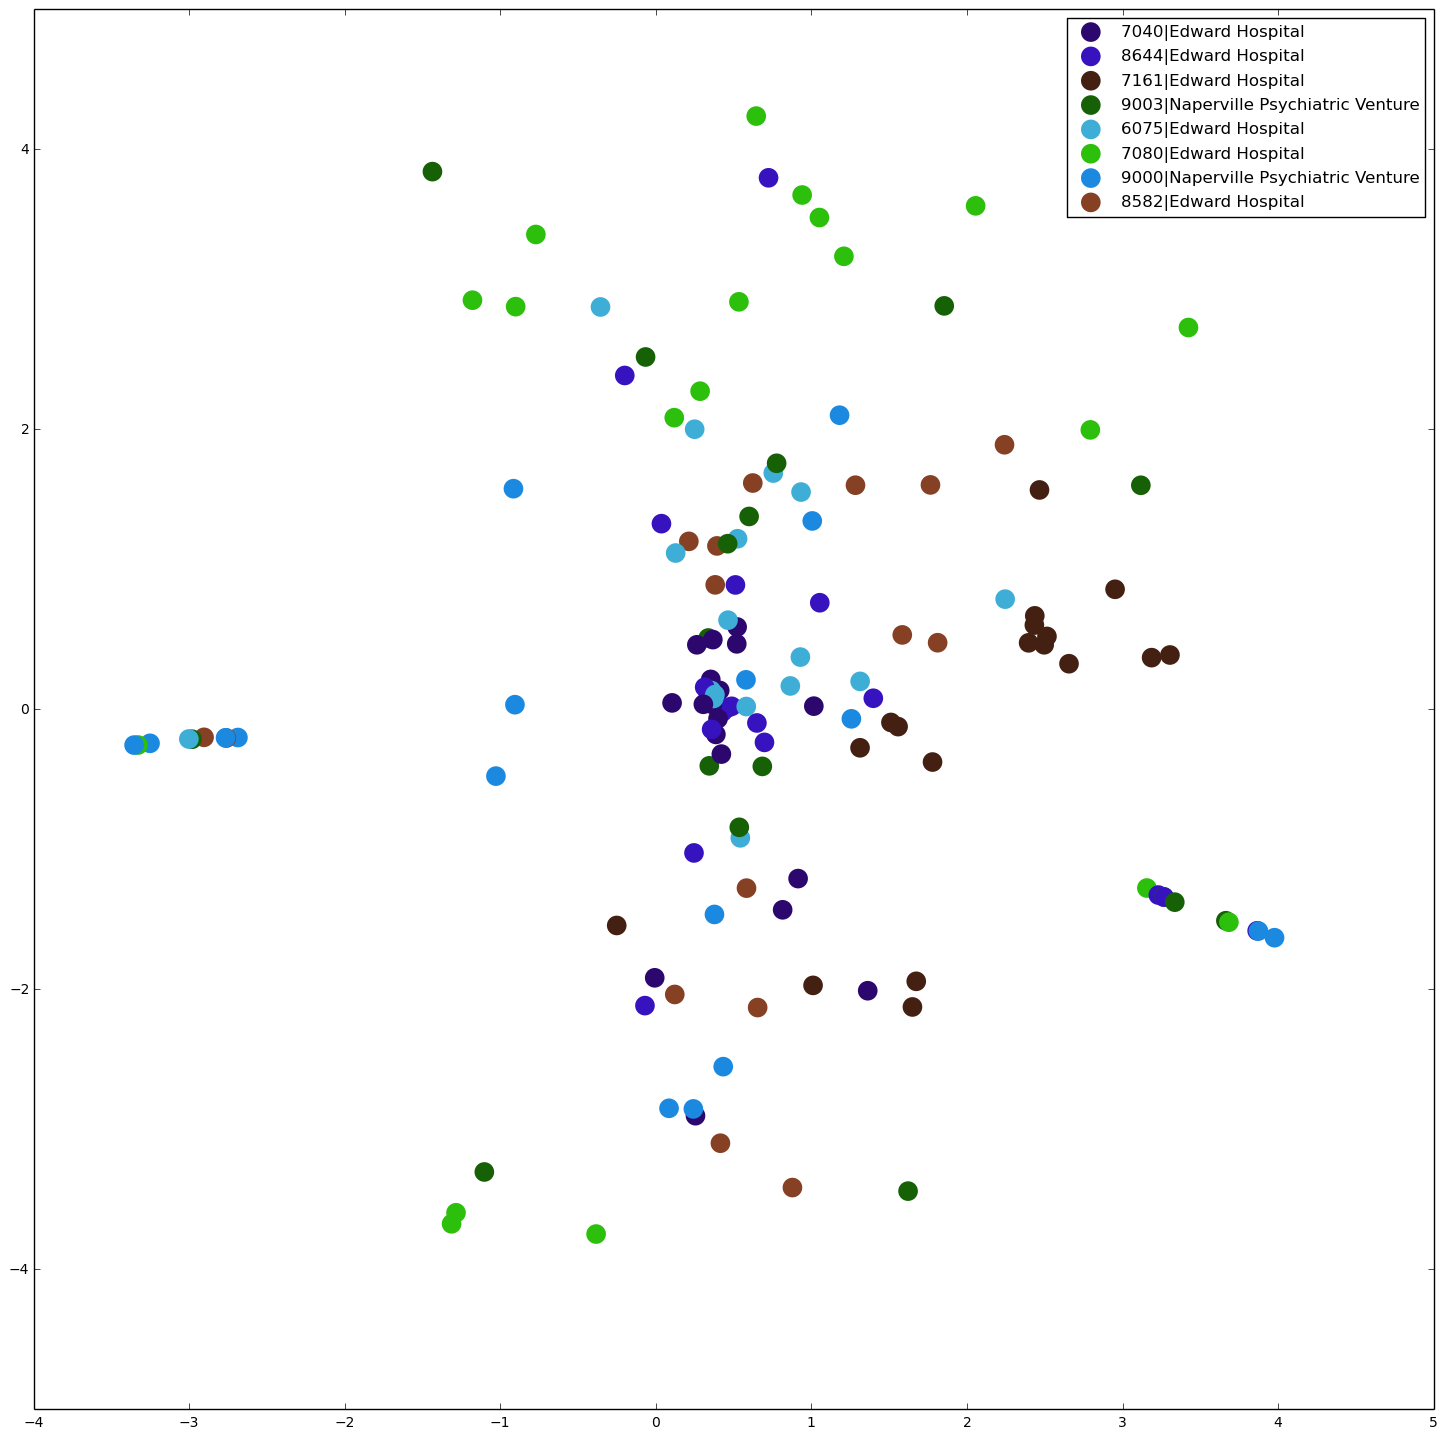

CPU times: user 2min 45s, sys: 15.4 s, total: 3min 1s
Wall time: 3min


In [19]:
%%time
### 16-20 
seed = np.random.RandomState(seed=3)
similarities = euclidean_distances(main1)

mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=300, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

X_true = main1

# Rescale the data
pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

#fig = plt.figure(1)
fig = plt.figure(figsize=(14, 14))
ax = plt.axes([0., 0., 1., 1.])

s = 200

max_ind = 0 
lables_d = {}
for ind, val in enumerate(zip(npos[:, 0], npos[:, 1])):
    for k, v in dict_with_dept.items():
        if ind in v[-1] and k != None and (15 < len(v[-1]) <= 20):
            #print(colors[v[0]], k)
            lables_d[k] = str(ind) + '_plt'
            globals()[str(ind) + '_plt'] = plt.scatter(val[0], val[1], color=colors[v[0]], s=s, lw=0, label=k)

l_colors = []
l_lable = []
for ind_l, val_l in lables_d.items():
    l_colors.append(globals()[val_l])
    l_lable.append(ind_l)
plt.legend(l_colors, l_lable, scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0


segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(0 * np.ones(len(segments)))
ax.add_collection(lc)

plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in divide


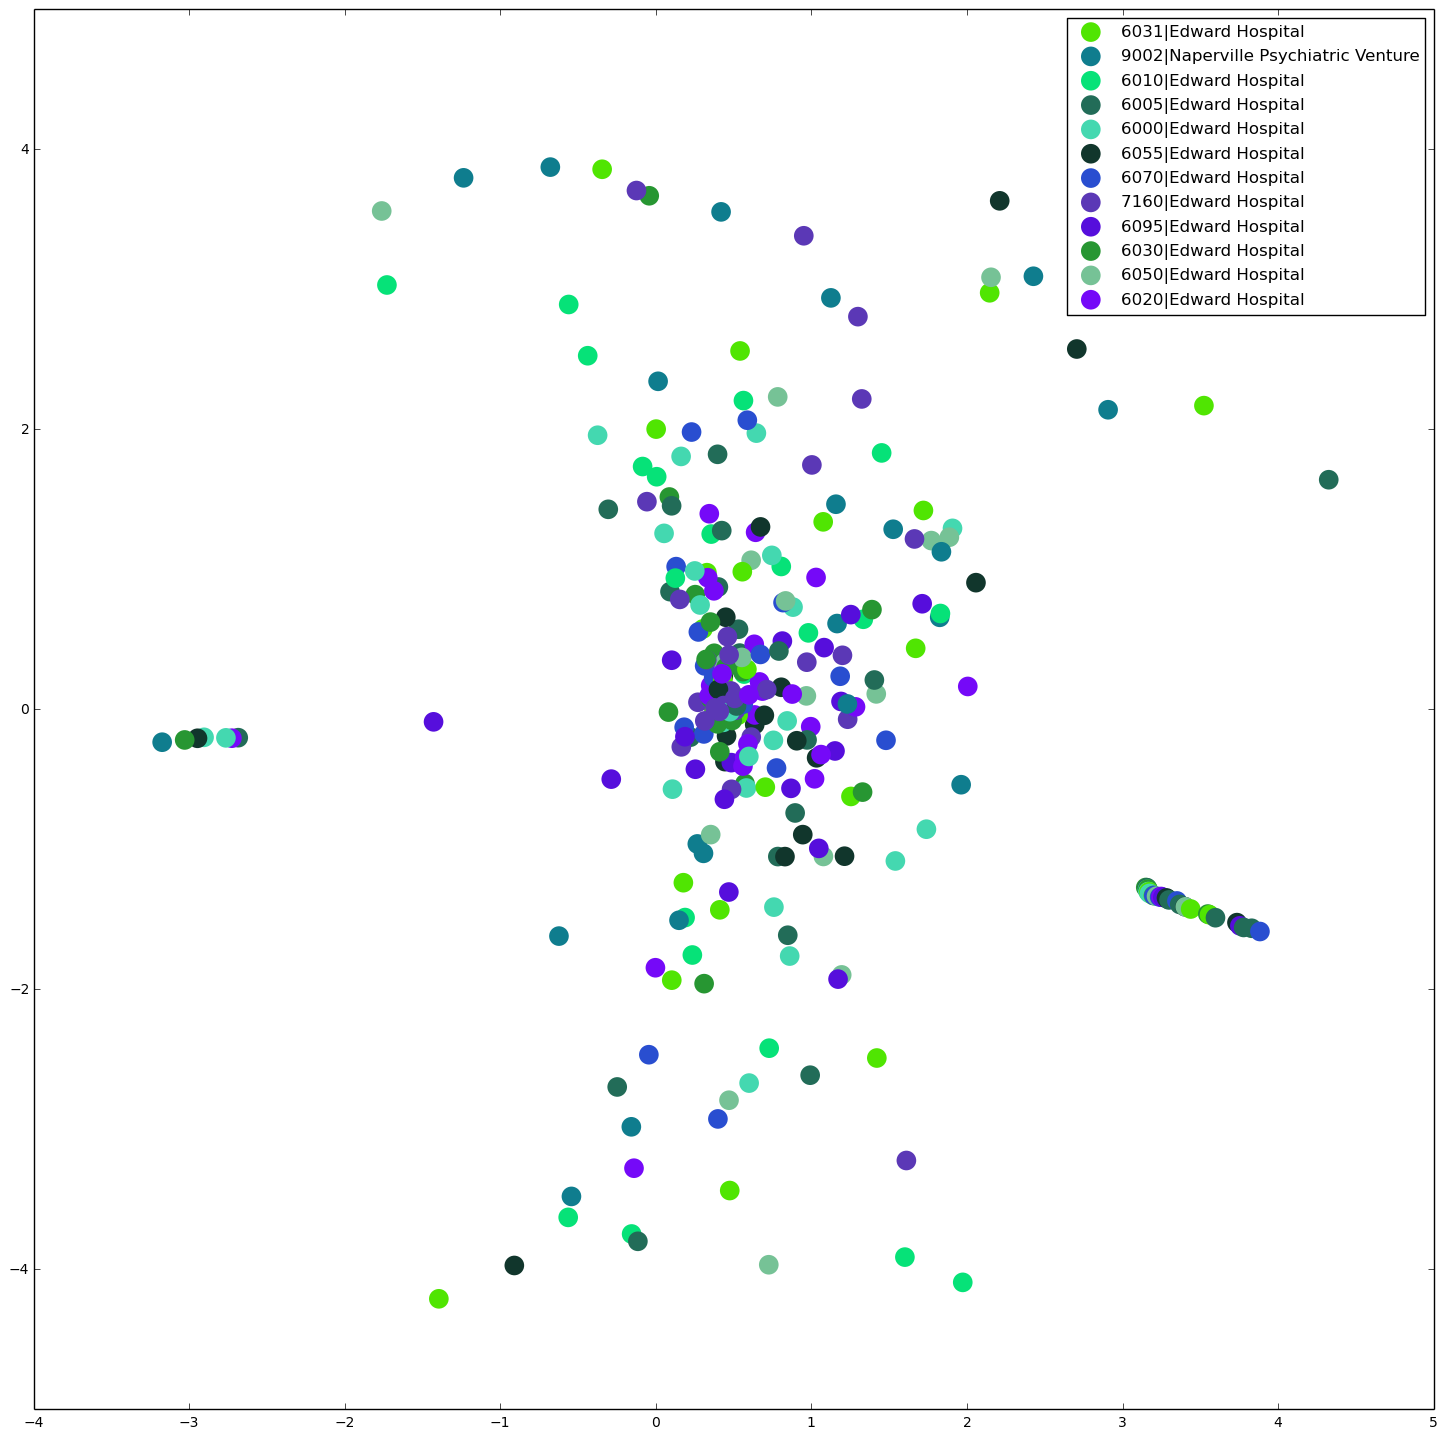

CPU times: user 2min 48s, sys: 2.6 s, total: 2min 51s
Wall time: 2min 51s


In [20]:
%%time
### >21 
seed = np.random.RandomState(seed=3)
similarities = euclidean_distances(main1)

mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=300, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

X_true = main1

# Rescale the data
pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

#fig = plt.figure(1)
fig = plt.figure(figsize=(14, 14))
ax = plt.axes([0., 0., 1., 1.])

s = 200

max_ind = 0 
lables_d = {}
for ind, val in enumerate(zip(npos[:, 0], npos[:, 1])):
    for k, v in dict_with_dept.items():
        if ind in v[-1] and k != None and (len(v[-1]) > 20):
            #print(colors[v[0]], k)
            lables_d[k] = str(ind) + '_plt'
            globals()[str(ind) + '_plt'] = plt.scatter(val[0], val[1], color=colors[v[0]], s=s, lw=0, label=k)

l_colors = []
l_lable = []
for ind_l, val_l in lables_d.items():
    l_colors.append(globals()[val_l])
    l_lable.append(ind_l)
plt.legend(l_colors, l_lable, scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0


segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(0 * np.ones(len(segments)))
ax.add_collection(lc)

plt.show()